In [1]:
# LIBRERÍAS PRINCIPALES
import pandas as pd                 # Manipulación de datos
import numpy as np                  # Cálculos numéricos
import matplotlib.pyplot as plt     # Gráficos básicos
import seaborn as sns               # Visualización avanzada
import requests                     # Para acceder a APIs como Binance o Blockchain
import time                         # Control de pausas entre llamadas API
import yfinance as yf              # Descargar precios históricos desde Yahoo Finance (si lo usas)

# 🎨 CONFIGURACIÓN GLOBAL DE ESTILO
plt.style.use("seaborn-v0_8-whitegrid")  # Fondo blanco limpio

# 🎨 PALETA UNIFICADA PARA GRÁFICAS (tonos más elegantes)
PALETA_SENTIMIENTOS = {
    "positive": "#4CAF50",   # Verde sobrio (positivo)
    "negative": "#E74C3C",   # Rojo elegante (negativo)
    "neutral":  "#7F8C8D",   # Gris elegante (neutral)
}

COLOR_BTC       = "#34495E"  # Azul grisáceo oscuro (para el precio BTC)
COLOR_SENT_POS  = "#2E8B57"  # Verde esmeralda (sentimiento positivo agregado)
COLOR_SENT_NEG  = "#B22222"  # Rojo vino (sentimiento negativo agregado)
COLOR_SENT_NET  = "#6A5ACD"  # Azul-violeta sobrio para sentimiento neto

# Análisis de sentimientos por día

In [2]:
# Cargar y preparar dataset de tweets

# Leer el archivo CSV comprimido
df = pd.read_csv("data/tweets_≥1M_seguidores_sentimientos.csv.gz", parse_dates=['date'])

# Asegurar el formato de fecha
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Mostrar un vistazo rápido
df.head(10)

,date,clean_text,sentiment_label,sentiment_score
0,2021-02-10 15:23:58,it has to be paof the menu says on #bitcoin on...,neutral,0.867605
1,2021-02-10 08:05:10,novogratz predicts #bitcoin price will hit thi...,neutral,0.706053
2,2021-02-09 09:35:01,bitcoin price will hit soon popular #analyst s...,neutral,0.706823
3,2021-02-09 03:49:00,#bitcoin is an asset says i think in the futur...,neutral,0.537262
4,2021-02-08 16:47:25,#bitcoin is an asset says i think in the futur...,neutral,0.537262
5,2021-02-08 14:19:04,#bitcoin hits k alltime high as #tesla invests...,neutral,0.661793
6,2021-02-08 13:16:51,breaking tesla bought b in #bitcoin sec filing...,neutral,0.896231
7,2021-02-08 07:22:09,list of countries where cryptocurrency trading...,negative,0.537727
8,2021-02-08 05:50:27,ripple cto david schwartz owes his sister over...,neutral,0.849540
9,2021-02-07 20:18:02,here are countries where cryptocurrency tradin...,neutral,0.870162


In [3]:
# Total de tweets
total_tweets = len(df)

# Rango de fechas
fecha_inicio = df['date'].min()
fecha_fin    = df['date'].max()

# Distribución de sentimientos (%)
sentiment_counts = df['sentiment_label'].value_counts(normalize=True) * 100

# Mostrar resumen
print(f"📈 Número total de tweets: {total_tweets:,}")
print(f"📆 Rango de fechas: {fecha_inicio.date()} → {fecha_fin.date()}")
print("\n📊 Distribución de sentimientos (%):")
print(sentiment_counts.round(2))

📈 Número total de tweets: 5,952
📆 Rango de fechas: 2021-02-06 → 2023-01-09

📊 Distribución de sentimientos (%):
sentiment_label
neutral     67.81
positive    21.86
negative    10.33
Name: proportion, dtype: float64


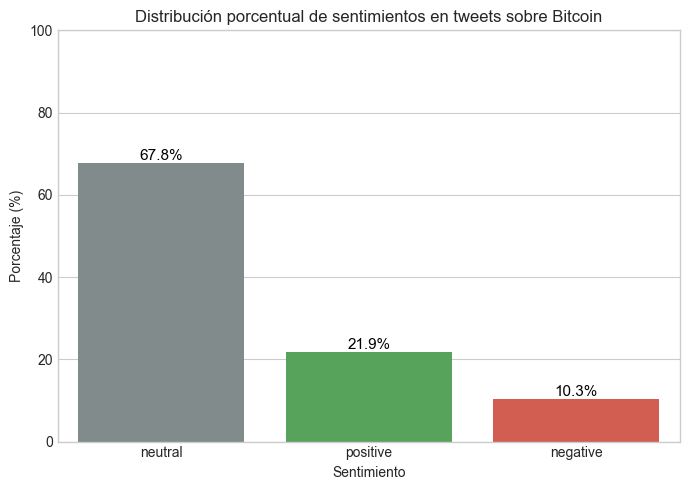

In [4]:
# Visualización de distribución de sentimientos

# Conteo y porcentaje de cada sentimiento
sent_counts = df['sentiment_label'].value_counts()
sent_perc = sent_counts / sent_counts.sum() * 100

# Crear el gráfico
plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x=sent_counts.index,
    y=sent_perc.values,
    hue=sent_counts.index,   # corrección de warning
    palette=[PALETA_SENTIMIENTOS.get(s, "#999999") for s in sent_counts.index],
)

# Añadir porcentajes encima de cada barra
for i, p in enumerate(ax.patches):
    ax.annotate(f"{sent_perc.values[i]:.1f}%",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black')

# Ajustes estéticos
plt.title("Distribución porcentual de sentimientos en tweets sobre Bitcoin")
plt.xlabel("Sentimiento")
plt.ylabel("Porcentaje (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [5]:
# Agrupar por fecha (solo día) y tipo de sentimiento
sentiment_over_time = (
    df.groupby([df['date'].dt.date, 'sentiment_label'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

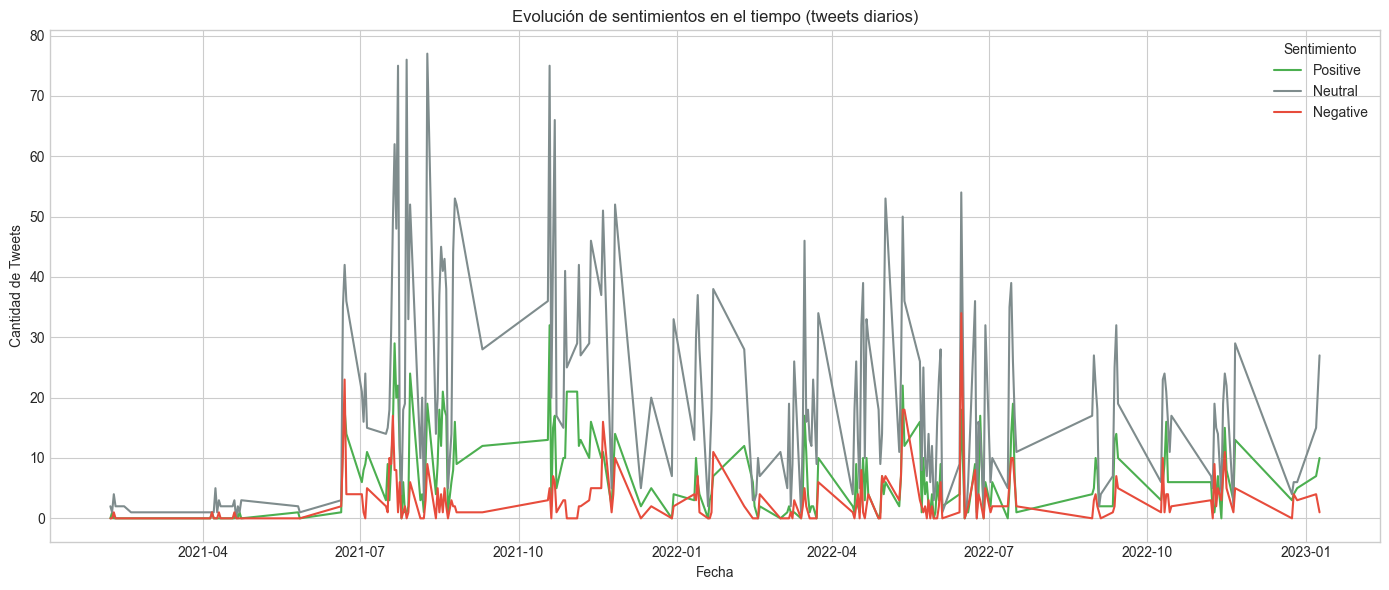

In [7]:
# 🔹 BLOQUE 1.3: Evolución temporal del sentimiento

plt.figure(figsize=(14, 6))

# Graficar cada tipo de sentimiento con color unificado
for sentiment in ['positive', 'neutral', 'negative']:
    if sentiment in sentiment_over_time.columns:
        plt.plot(
            sentiment_over_time.index,
            sentiment_over_time[sentiment],
            label=sentiment.capitalize(),
            color=PALETA_SENTIMIENTOS[sentiment],
            linewidth=1.5
        )

# Estética
plt.title("Evolución de sentimientos en el tiempo (tweets diarios)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Tweets")
plt.legend(title="Sentimiento")
plt.tight_layout()
plt.show()

# 📊 Análisis de Sentimientos en Cuentas con ≥1M Seguidores Verificados

### Resumen del dataset
- **Número total de tweets:** 5,952  
- **Rango de fechas:** 2021-02-06 → 2023-01-09  

### Distribución porcentual de sentimientos
- **Neutral:** 67.81%  
- **Positivo:** 21.86%  
- **Negativo:** 10.33%  

📈 El análisis muestra un claro predominio de la neutralidad, lo que sugiere que incluso las cuentas más influyentes mantienen un tono informativo o descriptivo sobre Bitcoin, más que opiniones extremas.  

---

## 📉 Evolución temporal de los sentimientos
- **Neutral:** domina en casi todo el periodo, con picos altos alrededor de **mediados de 2021** y **finales de 2021**, coincidiendo con momentos clave del mercado (máximos históricos y posterior corrección).  
- **Positivo:** presenta repuntes en los mismos periodos, aunque en menor volumen que los neutrales.  
- **Negativo:** se intensifica en **2022**, reflejando la narrativa bajista durante la caída prolongada del precio de BTC.  

---

## 🔄 Comparativa con el estudio de cuentas ≥10K seguidores
- En el dataset más amplio (≥10K seguidores), la distribución era:  
  - **Neutral ~67.8%**  
  - **Positivo ~20.6%**  
  - **Negativo ~11.6%**  

- En el dataset de cuentas más influyentes (≥1M verificados), los resultados son:  
  - **Neutral 67.81%**  
  - **Positivo 21.86%**  
  - **Negativo 10.33%**  

👉 **Conclusión comparativa:**  
Las cuentas de gran alcance muestran un patrón muy similar al de las cuentas ≥10K. El ligero aumento en el **tono positivo (+1.2 puntos)** y la **disminución del negativo (-1.3 puntos)** sugieren que los grandes emisores refuerzan una narrativa algo más optimista que la base amplia de usuarios.

In [8]:
# Asegurar que la fecha esté en formato de solo día
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['day'] = df['date'].dt.normalize()

# Agrupar por día y tipo de sentimiento
tweets_por_dia = (
    df.groupby(['day', 'sentiment_label'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

In [9]:
# Top 10 días con más tweets positivos y negativos
top_positivos = tweets_por_dia['positive'].sort_values(ascending=False).head(10)
top_negativos = tweets_por_dia['negative'].sort_values(ascending=False).head(10)

# Mostrar en consola
print("📊 Top 10 fechas con MÁS tweets POSITIVOS:\n", top_positivos)
print("\n📊 Top 10 fechas con MÁS tweets NEGATIVOS:\n", top_negativos)

📊 Top 10 fechas con MÁS tweets POSITIVOS:
 day
2021-10-19    32
2021-07-21    29
2021-07-30    24
2021-07-23    22
2022-05-12    22
2021-11-04    21
2021-08-18    21
2021-10-29    21
2021-07-22    20
2021-08-09    19
Name: positive, dtype: int64

📊 Top 10 fechas con MÁS tweets NEGATIVOS:
 day
2022-06-15    34
2021-06-22    23
2022-05-12    18
2022-05-13    18
2021-07-20    17
2021-11-19    16
2022-11-15    11
2021-06-21    11
2022-01-22    11
2022-07-14    10
Name: negative, dtype: int64


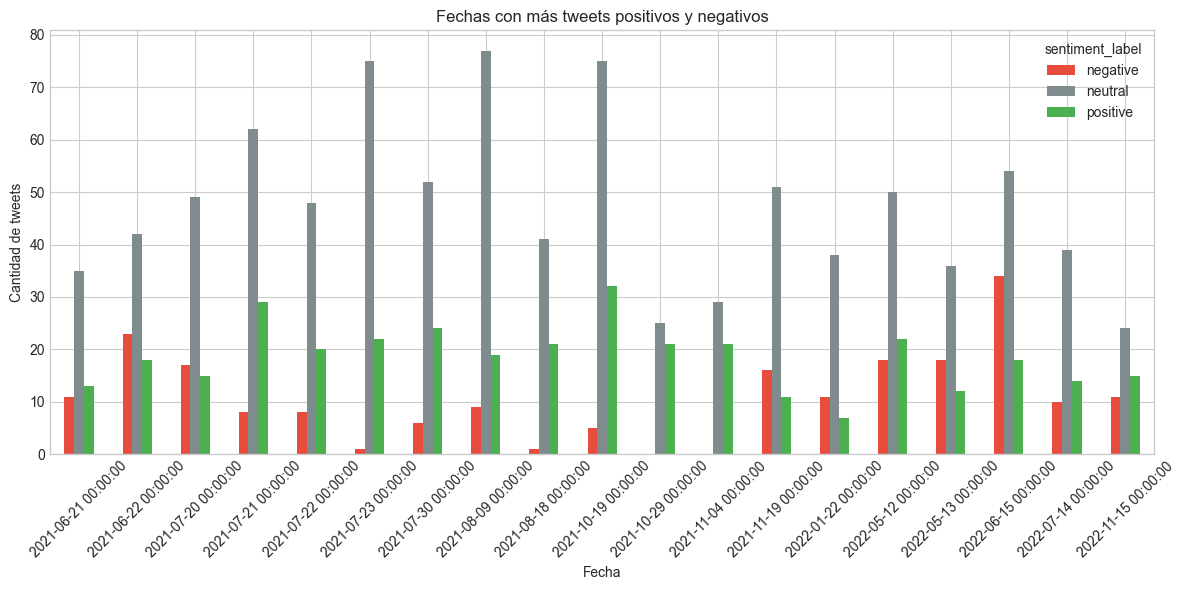

In [10]:
# Fechas únicas (unión de ambas listas)
fechas_destacadas = top_positivos.index.union(top_negativos.index)

# Subconjunto del DataFrame original
top_fechas = tweets_por_dia.loc[fechas_destacadas]

# Graficar
top_fechas.plot(kind='bar', figsize=(12, 6),
                color=[PALETA_SENTIMIENTOS.get(col, "#999999") for col in top_fechas.columns])

plt.title("Fechas con más tweets positivos y negativos")
plt.ylabel("Cantidad de tweets")
plt.xlabel("Fecha")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📊 Análisis de picos de sentimiento en cuentas ≥1M seguidores

Los resultados muestran que los **picos positivos** se concentraron en la segunda mitad de 2021, en pleno rally alcista de Bitcoin hacia máximos históricos. Estas fechas reflejan cómo las cuentas con gran alcance amplificaron el optimismo del mercado, contribuyendo a reforzar la narrativa de “subida imparable”. 

Por el contrario, los **picos negativos** se ubican sobre todo en mayo–junio 2022 y junio 2021, periodos de fuerte corrección: el colapso de Terra/Luna y la presión regulatoria en China. En estos momentos, las cuentas con más de un millón de seguidores actuaron como altavoces de la incertidumbre, acentuando el pesimismo general.

En conjunto, aunque la mayoría de los tweets de estas cuentas son neutrales, los episodios extremos muestran que su influencia es más marcada en contextos de volatilidad: **alimentan la euforia en los rallies y el miedo en las caídas**. Esto refuerza la idea de que el sentimiento no predice de forma sistemática la dirección de Bitcoin, pero sí acompaña y amplifica los movimientos ya iniciados en el mercado.

In [11]:
# Agrupar por día y tipo de sentimiento
daily = (
    df.groupby([df['date'].dt.normalize(), 'sentiment_label'])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=['positive', 'negative'], fill_value=0)
)

# Sentimiento neto diario
daily['sent_net'] = daily['positive'] - daily['negative']

In [14]:
# Rango de fechas
start = daily.index.min().date()
end   = daily.index.max().date()
days  = (end - start).days + 1

# Descargar datos desde Blockchain.com
url = f"https://api.blockchain.info/charts/market-price?start={start:%Y-%m-%d}&timespan={days}days&format=json"
data = requests.get(url, timeout=30).json()['values']

# Convertir a DataFrame
price = (
    pd.DataFrame(data)
      .assign(date=lambda df: pd.to_datetime(df['x'], unit='s').dt.normalize())
      .rename(columns={'y': 'price_usd'})
      .set_index('date')[['price_usd']]
      .sort_index()
)

In [16]:
# Unir sentimiento y precios por fecha
merged = daily.join(price, how='inner').copy()

# Retorno diario del BTC
merged['ret'] = merged['price_usd'].pct_change()

# Suavizado de sentimiento con media móvil de 7 días
merged['pos_7d'] = merged['positive'].rolling(7, min_periods=3).sum()
merged['neg_7d'] = merged['negative'].rolling(7, min_periods=3).sum()
merged['sent_net_7d'] = merged['sent_net'].rolling(7, min_periods=3).mean()

In [17]:
# Correlación en el mismo día
corr_same_day = merged['sent_net_7d'].corr(merged['ret'])

# Correlación con 1 día de adelanto
corr_lead_1d = merged['sent_net_7d'].shift(1).corr(merged['ret'])

# Mostrar resultados
print(f"📊 Correlación (sent_net_7d vs retorno mismo día): {corr_same_day:.3f}")
print(f"📊 Correlación (sent_net_7d adelantado 1 día vs retorno): {corr_lead_1d:.3f}")

📊 Correlación (sent_net_7d vs retorno mismo día): 0.109
📊 Correlación (sent_net_7d adelantado 1 día vs retorno): 0.077


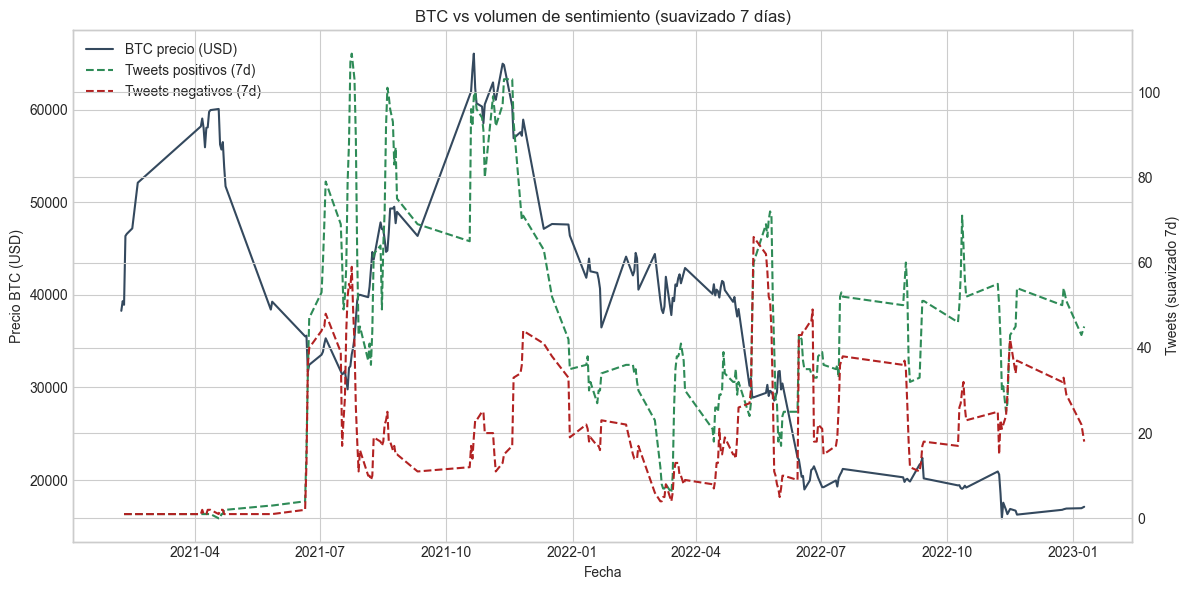

In [18]:
# Gráfico combinado con dos ejes Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Precio BTC
ax1.plot(merged.index, merged['price_usd'], color=COLOR_BTC, label='BTC precio (USD)')
ax1.set_ylabel('Precio BTC (USD)')
ax1.set_xlabel('Fecha')

# Tweets positivos y negativos suavizados (eje secundario)
ax2 = ax1.twinx()
ax2.plot(merged.index, merged['pos_7d'], linestyle='--', color=COLOR_SENT_POS, label='Tweets positivos (7d)')
ax2.plot(merged.index, merged['neg_7d'], linestyle='--', color=COLOR_SENT_NEG, label='Tweets negativos (7d)')
ax2.set_ylabel('Tweets (suavizado 7d)')

# Título y leyenda
ax1.set_title('BTC vs volumen de sentimiento (suavizado 7 días)')
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
# Detectar picos de sentimiento (top 5 días con más positivos o negativos)
events_pos = daily['positive'].nlargest(5).rename('pos_peak')
events_neg = daily['negative'].nlargest(5).rename('neg_peak')

# Combinar en tabla de eventos
evt = pd.concat([events_pos, events_neg], axis=1)
evt['price'] = merged['price_usd']
evt['ret_next_1d'] = merged['ret'].shift(-1)

# Limpiar y redondear
evt = evt.dropna().round({'ret_next_1d': 4})

# Mostrar tabla final
print("\n📌 Top picos y retorno al día siguiente:")
print(evt[['pos_peak', 'neg_peak', 'price', 'ret_next_1d']])


📌 Top picos y retorno al día siguiente:
            pos_peak  neg_peak     price  ret_next_1d
date                                                 
2022-05-12      22.0      18.0  28907.15       0.0008


# 📊 Relación entre sentimiento (≥1M seguidores) y precio de BTC

El contraste entre sentimiento y precio en este grupo reducido de cuentas influyentes confirma la hipótesis de que el sentimiento **acompaña** más que anticipa los movimientos de mercado:  

- Los **picos de sentimiento positivo** aparecen en paralelo a fases de euforia del mercado, reforzando narrativas alcistas ya en marcha.  
- Los **picos negativos** se concentran en caídas fuertes, como el caso del **12 de mayo de 2022**, durante el colapso de Terra/Luna.  

### 🔎 Correlaciones encontradas
- 📊 **Correlación (sent_net_7d vs retorno mismo día):** 0.109  
- 📊 **Correlación (sent_net_7d adelantado 1 día vs retorno):** 0.077  

Estas cifras muestran que la relación es **débil y no significativa en términos predictivos**.  

### 📌 Top picos y retorno al día siguiente
| Fecha       | Tweets positivos | Tweets negativos | Precio BTC (USD) | Retorno siguiente día |
|-------------|------------------|------------------|------------------|-----------------------|
| 2022-05-12  | 22               | 18               | 28,907.15        | +0.0008               |

👉 En conclusión: incluso en cuentas de gran alcance (≥1M seguidores), el sentimiento funciona como un **termómetro del mercado**, amplificando la narrativa (optimismo o miedo) en tiempo real, pero sin ofrecer valor predictivo sobre el precio futuro de Bitcoin.

Filas unidas: 202 | Rango: 2021-02-06 → 2023-01-09
Correlación (sent_net_7d vs retorno): 0.093


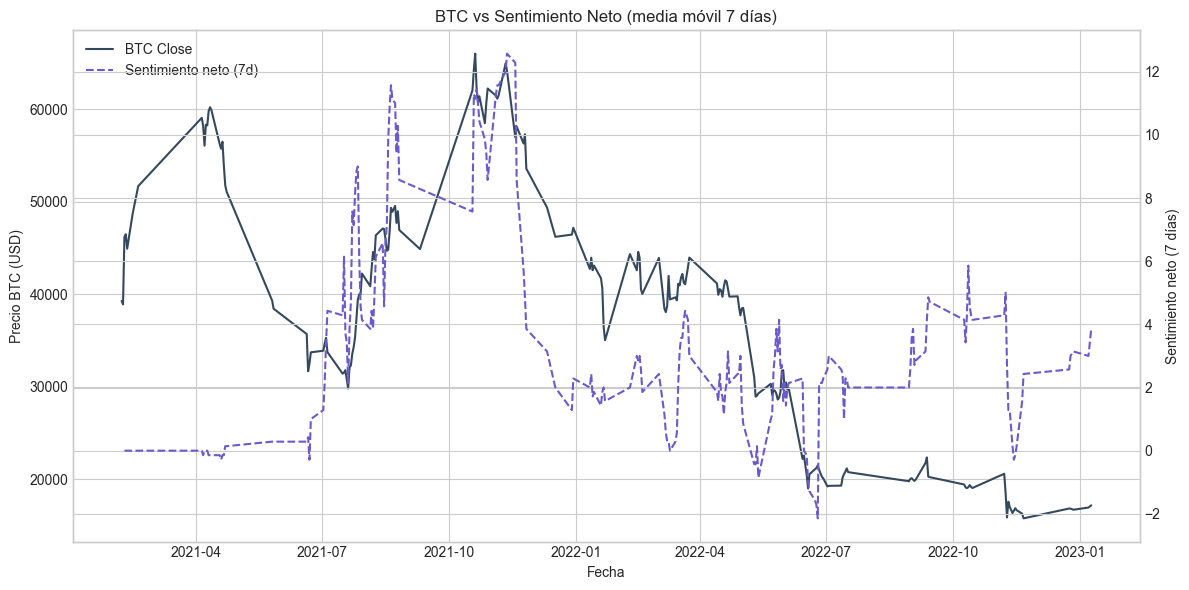

Correlación (sent_net_7d vs retorno mismo día): 0.093
Correlación (sent_net_7d adelantado 1 día vs retorno): 0.079


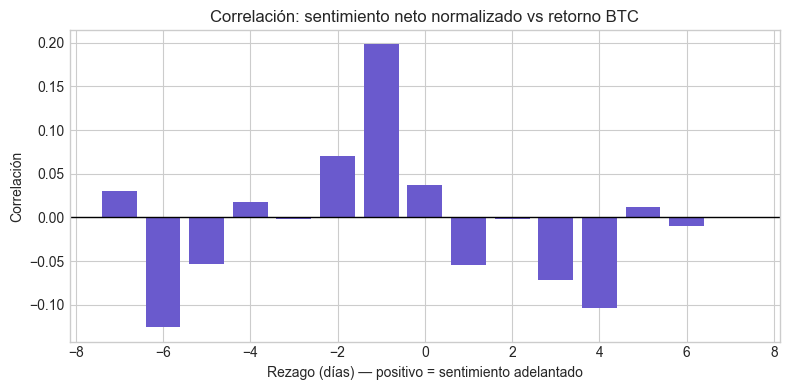

Mejor rezago: -1 días | Correlación máxima: 0.198


In [21]:
# Renombrar columnas para unificar formatos
if 'Date' not in df.columns and 'date' in df.columns:
    df = df.rename(columns={'date': 'Date'})

if 'Sentiment' not in df.columns:
    if 'sentiment' in df.columns:
        df = df.rename(columns={'sentiment': 'Sentiment'})
    elif 'sentiment_label' in df.columns:
        df['Sentiment'] = df['sentiment_label'].astype(str).str.strip().str.lower().map(
            {'positive': 'Positive', 'negative': 'Negative', 'neutral': 'Neutral'}
        )
    else:
        raise ValueError("No se encuentra la columna de sentimiento ('Sentiment' o 'sentiment_label').")

# Calcular sentimiento neto diario a partir del DataFrame de tweets
df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.normalize()
sent_daily = (
    df.groupby(['Date','Sentiment']).size()
      .unstack(fill_value=0)
      .reindex(columns=['Positive','Negative','Neutral'], fill_value=0)
      .reset_index()
)
sent_daily['sent_net'] = sent_daily['Positive'] - sent_daily['Negative']

# Descargar precios históricos de BTC desde Yahoo Finance
btc = yf.download(
    "BTC-USD",
    start=sent_daily['Date'].min().date(),
    end=(sent_daily['Date'].max() + pd.Timedelta(days=1)).date(),
    auto_adjust=False,
    progress=False
)
df_btc = btc.reset_index()
df_btc.rename(columns={df_btc.columns[0]: 'Date'}, inplace=True)
df_btc = df_btc[['Date','Close']].copy()
df_btc['Date'] = pd.to_datetime(df_btc['Date']).dt.normalize()

# Asegurar que ambas tablas tengan columnas planas (no MultiIndex)
if isinstance(df_btc.columns, pd.MultiIndex):
    df_btc.columns = df_btc.columns.get_level_values(0)

if isinstance(sent_daily.columns, pd.MultiIndex):
    sent_daily.columns = sent_daily.columns.get_level_values(0)

# Unir sentimiento neto con precios BTC por fecha
merged = pd.merge(df_btc, sent_daily[['Date','sent_net']], on='Date', how='inner')
merged = merged.sort_values('Date').reset_index(drop=True)

# Calcular retorno diario de BTC y sentimiento neto suavizado (media móvil 7 días)
merged['ret'] = merged['Close'].pct_change()
merged['sent_net_7d'] = merged['sent_net'].rolling(7, min_periods=3).mean()

# Mostrar información general y correlación básica
print("Filas unidas:", len(merged), "| Rango:", merged['Date'].min().date(), "→", merged['Date'].max().date())
print("Correlación (sent_net_7d vs retorno):", round(merged['sent_net_7d'].corr(merged['ret']), 3))

# Visualizar evolución del precio BTC y el sentimiento neto (media móvil 7 días)
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(merged['Date'], merged['Close'], label='BTC Close', color=COLOR_BTC)
ax1.set_ylabel('Precio BTC (USD)')
ax1.set_xlabel('Fecha')

ax2 = ax1.twinx()
ax2.plot(merged['Date'], merged['sent_net_7d'], linestyle='--', label='Sentimiento neto (7d)', color=COLOR_SENT_NET)
ax2.set_ylabel('Sentimiento neto (7 días)')

lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
plt.title('BTC vs Sentimiento Neto (media móvil 7 días)')
plt.tight_layout()
plt.show()

# Calcular correlaciones: mismo día y con sentimiento adelantado 1 día
corr_same_day = merged['sent_net_7d'].corr(merged['ret'])
corr_lead_1d = merged['sent_net_7d'].shift(1).corr(merged['ret'])

print(f"Correlación (sent_net_7d vs retorno mismo día): {corr_same_day:.3f}")
print(f"Correlación (sent_net_7d adelantado 1 día vs retorno): {corr_lead_1d:.3f}")

# Añadir conteo detallado de tweets por clase de sentimiento
cols_to_drop = [c for c in ['Positive','Negative','Neutral','pos','neg','neu','total_tweets','sent_net','sent_net_norm'] if c in merged.columns]
merged = merged.drop(columns=cols_to_drop, errors='ignore')
merged = merged.merge(sent_daily, on='Date', how='left').fillna({'Positive':0,'Negative':0,'Neutral':0})

merged['pos'] = merged['Positive'].astype(int)
merged['neg'] = merged['Negative'].astype(int)
merged['neu'] = merged['Neutral'].astype(int)

# Calcular sentimiento neto y sentimiento neto normalizado por volumen diario
merged['sent_net'] = merged['pos'] - merged['neg']
merged['total_tweets'] = merged['pos'] + merged['neg'] + merged['neu']
merged['sent_net_norm'] = (merged['sent_net'] / merged['total_tweets'].replace(0, pd.NA)).fillna(0)

# Calcular retorno diario final para análisis de correlaciones avanzadas
merged = merged.sort_values('Date').reset_index(drop=True)
merged['ret'] = merged['Close'].pct_change()

# Visualizar primeras filas para revisión rápida
merged[['Date','Close','pos','neg','neu','sent_net','sent_net_norm','ret']].head(3)

# Calcular correlación cruzada entre sentimiento neto normalizado y retornos con rezagos
lags = range(-7, 8)
corrs = [ merged['sent_net_norm'].shift(l).corr(merged['ret']) for l in lags ]
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = np.nanmax(corrs)

# Visualizar correlación por rezago entre sentimiento neto y retornos BTC
plt.figure(figsize=(8,4))
plt.bar(list(lags), corrs, color=COLOR_SENT_NET)
plt.axhline(0, color='k', lw=1)
plt.title('Correlación: sentimiento neto normalizado vs retorno BTC')
plt.xlabel('Rezago (días) — positivo = sentimiento adelantado')
plt.ylabel('Correlación')
plt.tight_layout()
plt.show()

print(f"Mejor rezago: {best_lag} días | Correlación máxima: {best_corr:.3f}")

## 1. Evolución BTC vs Sentimiento Neto
La comparación entre el precio de Bitcoin y el **sentimiento neto suavizado (7 días)** confirma que ambos siguen trayectorias similares en ciertos periodos (ej. repuntes en la segunda mitad de 2021 y caídas en 2022).  
Sin embargo, no existe una **relación de liderazgo clara**: el sentimiento refleja más bien la dinámica del precio, con pequeños rezagos de corto plazo.

## 2. Correlaciones entre sentimiento y retornos
- **Filas analizadas**: 202  
- **Rango temporal**: 2021-02-06 → 2023-01-09  

- **Correlación (sent_net_7d vs retorno mismo día):** 0.093 → débil relación, sin poder predictivo.  
- **Correlación (sent_net_7d adelantado 1 día vs retorno):** 0.079 → aún más bajo, indicando que el sentimiento no anticipa movimientos futuros.  

- **Lags (-7 a +7 días):**  
  - La correlación máxima se da en **-1 día ≈ 0.198**, lo que significa que **los retornos de BTC tienden a influir en el sentimiento del día siguiente**, no al revés.  
  - El patrón general muestra correlaciones más altas en rezagos negativos y valores bajos/erráticos en rezagos positivos → confirmando que los **inversores reaccionan al mercado**.  

## 3. Conclusión general (≥1M seguidores)
- El **sentimiento neto** de cuentas con ≥1M seguidores no presenta capacidad predictiva robusta sobre el precio de BTC.  
- Los datos sugieren que el **precio lidera y el sentimiento responde**, incluso en emisores de gran alcance.  
- Comparado con el estudio previo (≥10K seguidores):  
  - Los patrones se mantienen consistentes (neutralidad predominante, positivos en alzas y negativos en caídas).  
  - El volumen de tweets en ≥1M seguidores es muy bajo (**5,952 vs 398k**), lo que reduce aún más la capacidad de explicar el movimiento de precios.  

📌 **Implicación**: incluso limitando el análisis a cuentas “influyentes”, el sentimiento en Twitter funciona como un **termómetro reactivo**, no como un predictor adelantado del mercado de Bitcoin.

# Análisis de sentimientos por horas

In [22]:
# Cargar dataset comprimido con tweets de Bitcoin y parsear la columna de fecha
df = pd.read_csv("data/tweets_≥1M_seguidores_sentimientos.csv.gz", parse_dates=['date'])

# Mostrar las primeras filas del DataFrame para inspección inicial
df.head()

,date,clean_text,sentiment_label,sentiment_score
0,2021-02-10 15:23:58,it has to be paof the menu says on #bitcoin on...,neutral,0.867605
1,2021-02-10 08:05:10,novogratz predicts #bitcoin price will hit thi...,neutral,0.706053
2,2021-02-09 09:35:01,bitcoin price will hit soon popular #analyst s...,neutral,0.706823
3,2021-02-09 03:49:00,#bitcoin is an asset says i think in the futur...,neutral,0.537262
4,2021-02-08 16:47:25,#bitcoin is an asset says i think in the futur...,neutral,0.537262


In [23]:
# Convertir la columna 'date' a formato datetime y extraer la hora redondeada
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['hour'] = df['date'].dt.floor('h')  # Redondear a la hora más cercana

# Agrupar por hora y etiqueta de sentimiento, y calcular sentimiento neto
sent_hourly = (
    df.groupby(['hour', 'sentiment_label']).size().unstack(fill_value=0)
)
sent_hourly['sent_net'] = sent_hourly.get('positive', 0) - sent_hourly.get('negative', 0)

# Reiniciar índice para convertir 'hour' en columna y mostrar primeros registros
sent_hourly = sent_hourly.reset_index()
sent_hourly.head()

sentiment_label,hour,negative,neutral,positive,sent_net
0,2021-02-06 13:00:00,0,2,0,0
1,2021-02-07 14:00:00,0,0,1,1
2,2021-02-07 20:00:00,0,1,0,0
3,2021-02-08 05:00:00,0,1,0,0
4,2021-02-08 07:00:00,1,0,0,-1


In [24]:
# Definir función para obtener precios horarios de BTC desde la API de Binance
def get_binance_klines(symbol: str, interval: str, start, end) -> pd.DataFrame:
    url = "https://api.binance.com/api/v3/klines"
    start_ms = int(pd.Timestamp(start, tz='UTC').timestamp() * 1000)
    end_ms   = int(pd.Timestamp(end,   tz='UTC').timestamp() * 1000)
    out = []

    while start_ms < end_ms:
        params = dict(symbol=symbol, interval=interval, startTime=start_ms, endTime=end_ms, limit=1000)
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        chunk = r.json()
        if not chunk:
            break
        out.extend(chunk)
        start_ms = chunk[-1][0] + 60 * 60 * 1000  # Avanzar a la siguiente hora
        time.sleep(0.2)  # Pausa para evitar saturar el API

    # Definir columnas y formatear el DataFrame
    cols = ["open_time", "open", "high", "low", "close", "volume",
            "close_time", "qav", "num_trades", "taker_buy_base",
            "taker_buy_quote", "ignore"]
    dfb = pd.DataFrame(out, columns=cols)

    # Convertir el timestamp de apertura a datetime y extraer la hora
    dfb['hour']  = pd.to_datetime(dfb['open_time'], unit='ms', utc=True).dt.tz_convert(None).dt.floor('h')
    dfb['Close'] = dfb['close'].astype(float)

    return dfb[['hour', 'Close']]

# Definir rango de fechas en base al DataFrame de sentimientos por hora
start_dt = sent_hourly['hour'].min()
end_dt   = sent_hourly['hour'].max()

# Obtener precios horarios de BTC para ese rango
btc_hourly = get_binance_klines("BTCUSDT", "1h", start_dt, end_dt)
btc_hourly.head()

,hour,Close
0,2021-02-06 13:00:00,40130.47
1,2021-02-06 14:00:00,40268.44
2,2021-02-06 15:00:00,40864.73
3,2021-02-06 16:00:00,40608.76
4,2021-02-06 17:00:00,40197.01


In [25]:
# Unir los precios horarios de BTC con el sentimiento neto por hora
merged_h = (
    pd.merge(btc_hourly, sent_hourly[['hour', 'sent_net']], on='hour', how='inner')
      .sort_values('hour')
      .reset_index(drop=True)
)

# Calcular el retorno porcentual horario de BTC
merged_h['ret'] = merged_h['Close'].pct_change()

# Normalizar el sentimiento neto por hora (media cero, desviación estándar uno)
merged_h['sent_net_norm'] = (merged_h['sent_net'] - merged_h['sent_net'].mean()) / merged_h['sent_net'].std()

# Imprimir resumen de registros y correlación entre sentimiento neto normalizado y retorno horario
print("Filas unidas (horarias):", len(merged_h))
print("Correlación (mismo hora):", round(merged_h['sent_net_norm'].corr(merged_h['ret']), 3))

Filas unidas (horarias): 2298
Correlación (mismo hora): -0.004


In [27]:
# Calcular correlaciones entre sentimiento neto normalizado y retornos horarios con distintos rezagos
lags = range(-24, 25)  # Rezagos desde -24 horas (1 día antes) hasta +24 horas (1 día después)
corrs = [merged_h['sent_net_norm'].shift(l).corr(merged_h['ret']) for l in lags]

# Identificar el rezago con la correlación máxima
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = float(np.nanmax(corrs))

# Mostrar el mejor rezago y su correlación
best_lag, best_corr

(-4, 0.10426403477739098)

# Análisis de sentimientos por horas (cuentas ≥1M seguidores)

## 1. Datos de referencia
- Tweets agregados por hora: **2,298**  
- Rango temporal: 2021-02-06 → 2023-01-09  
- Correlación sentimiento neto vs retornos (misma hora): **-0.004** → prácticamente nula.  

## 2. Correlaciones por rezagos
- Máxima correlación: **0.104** con **rezago de -4 horas**.  
- Interpretación: los movimientos de precio tienden a reflejarse en el sentimiento de Twitter unas 4 horas después, no al revés.  
- Correlaciones positivas en rezagos negativos y débiles/erráticas en rezagos positivos confirman que el **precio lidera, el sentimiento reacciona**.  

## 3. Conclusiones clave
1. **Predicción débil**: el sentimiento horario no anticipa cambios en BTC; más bien sigue la dirección del mercado con unas pocas horas de retraso.  
2. **Neutralidad predominante**: la mayor parte de los tweets son neutrales, lo que reduce la señal útil.  
3. **Consistencia con otros horizontes** (diario y minutos): el patrón se repite, el sentimiento de cuentas influyentes en Twitter refleja los movimientos ya ocurridos en BTC y no aporta valor predictivo directo.  
4. **Implicación práctica**: para trading, los datos horarios de sentimiento en Twitter tienen **más valor explicativo que predictivo**.  

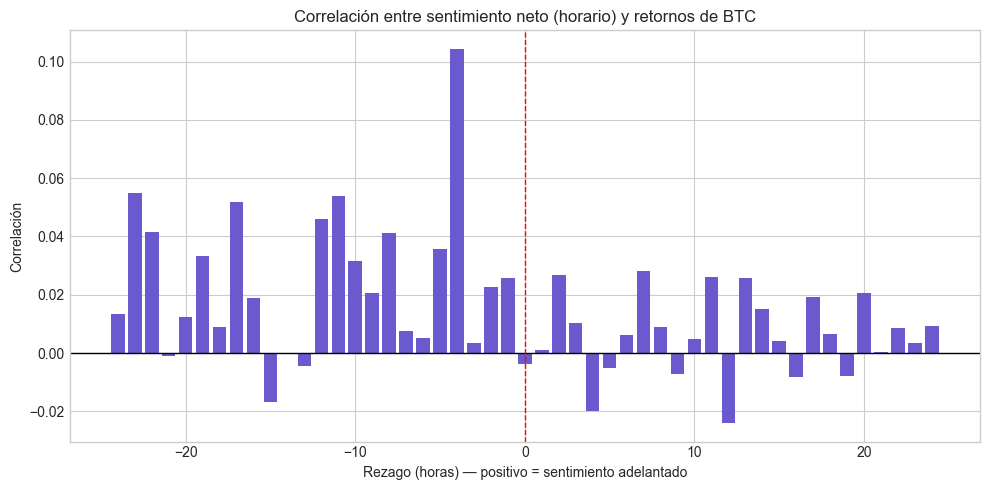

Mejor rezago: -4 horas | Correlación: 0.104


In [28]:
# Definir rezagos desde -24 hasta +24 horas para explorar relación temporal
lags = range(-24, 25)

# Calcular correlación entre sentimiento neto normalizado y retorno horario para cada rezago
corrs = [merged_h['sent_net_norm'].shift(l).corr(merged_h['ret']) for l in lags]

# Identificar el rezago con la correlación máxima
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = float(np.nanmax(corrs))

# Visualizar correlación por rezago horario
plt.figure(figsize=(10, 5))
plt.bar(list(lags), corrs, color=COLOR_SENT_NET)  # Usar color unificado del estilo
plt.axhline(0, color='k', lw=1)                   # Línea horizontal en y=0
plt.axvline(0, color='red', linestyle='--', lw=1) # Línea vertical en x=0 (sin rezago)
plt.title("Correlación entre sentimiento neto (horario) y retornos de BTC")
plt.xlabel("Rezago (horas) — positivo = sentimiento adelantado")
plt.ylabel("Correlación")
plt.tight_layout()
plt.show()

# Mostrar el mejor rezago y su valor de correlación
print(f"Mejor rezago: {best_lag} horas | Correlación: {best_corr:.3f}")

# Sentimiento horario vs Retornos de BTC

## Resultados clave
- **Mejor rezago:** -4 horas  
- **Correlación máxima:** 0.104  

## Interpretación
- El **sentimiento en Twitter reacciona** al precio con unas 4 horas de retraso.  
- No se observa evidencia de que el sentimiento horario **prediga** los movimientos de BTC.  
- La señal más fuerte sigue estando en rezagos **negativos** (precio → sentimiento), no al revés.

## Implicaciones
- El valor de este análisis horario es **explicativo y descriptivo**, mostrando cómo reaccionan las cuentas influyentes en Twitter a los movimientos del mercado.  
- Para fines de **trading o inversión**, los datos horarios de sentimiento **no añaden ventaja predictiva**, pero sí ayudan a entender la dinámica social alrededor de Bitcoin.

# Análisis de sentimientos por minutos

In [29]:
# Asegurar que la columna 'date' esté en formato datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Redondear cada timestamp al minuto más cercano
df['minute'] = df['date'].dt.floor('min')

# Agrupar por minuto y sentimiento, y calcular sentimiento neto
sent_min = (
    df.groupby(['minute', 'sentiment_label']).size().unstack(fill_value=0)
)
sent_min['sent_net'] = sent_min.get('positive', 0) - sent_min.get('negative', 0)

# Reiniciar índice y mostrar información general
sent_min = sent_min.reset_index()
print("Rango de fechas:", sent_min['minute'].min(), "→", sent_min['minute'].max())
print("Filas (minutos con tweets):", len(sent_min))

# Vista previa de los datos procesados
sent_min.head()

Rango de fechas: 2021-02-06 13:23:00 → 2023-01-09 21:37:00
Filas (minutos con tweets): 5641


sentiment_label,minute,negative,neutral,positive,sent_net
0,2021-02-06 13:23:00,0,1,0,0
1,2021-02-06 13:47:00,0,1,0,0
2,2021-02-07 14:51:00,0,0,1,1
3,2021-02-07 20:18:00,0,1,0,0
4,2021-02-08 05:50:00,0,1,0,0


## Mayo 2021

In [31]:
# Convertir la columna 'date' a formato datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filtrar solo los tweets correspondientes a mayo de 2021
mask = (df['date'] >= "2021-05-01") & (df['date'] < "2021-06-01")
df_may = df.loc[mask].copy()

# Redondear timestamps al minuto más cercano
df_may['minute'] = df_may['date'].dt.floor('min')

# Agrupar por minuto y sentimiento, y calcular sentimiento neto
sent_min = (
    df_may.groupby(['minute', 'sentiment_label']).size().unstack(fill_value=0)
)
sent_min['sent_net'] = sent_min.get('positive', 0) - sent_min.get('negative', 0)

# Reiniciar índice y mostrar información general
sent_min = sent_min.reset_index()
print("Tweets agregados por minuto (mayo 2021):", len(sent_min))

# Vista previa de los datos procesados por minuto
sent_min.head()

Tweets agregados por minuto (mayo 2021): 4


sentiment_label,minute,neutral,positive,sent_net
0,2021-05-26 12:00:00,1,0,0
1,2021-05-26 14:00:00,0,1,1
2,2021-05-26 15:03:00,1,0,0
3,2021-05-27 05:04:00,1,0,0


In [32]:
# Definir función para descargar precios de BTC por minuto desde la API de Binance
def get_binance_klines(symbol: str, interval: str, start, end):
    url = "https://api.binance.com/api/v3/klines"
    start_ms = int(pd.Timestamp(start, tz='UTC').timestamp() * 1000)
    end_ms   = int(pd.Timestamp(end, tz='UTC').timestamp() * 1000)
    out = []

    while start_ms < end_ms:
        params = dict(
            symbol=symbol,
            interval=interval,
            startTime=start_ms,
            endTime=end_ms,
            limit=1000
        )
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        chunk = r.json()
        if not chunk:
            break
        out.extend(chunk)
        start_ms = chunk[-1][0] + 60_000  # Avanzar un minuto (60,000 ms)
        time.sleep(0.15)  # Pausa para no sobrecargar el API

    # Crear DataFrame con columnas relevantes
    cols = ["open_time", "open", "high", "low", "close", "volume",
            "close_time", "qav", "num_trades", "taker_buy_base",
            "taker_buy_quote", "ignore"]
    dfp = pd.DataFrame(out, columns=cols)

    # Convertir tiempo de apertura a datetime sin zona horaria y redondear al minuto
    dfp['minute'] = pd.to_datetime(dfp['open_time'], unit='ms', utc=True).dt.tz_convert(None).dt.floor('min')
    dfp['Close']  = dfp['close'].astype(float)

    return dfp[['minute', 'Close']]

# Descargar precios minuto a minuto para el rango mayo 2021
btc_may = get_binance_klines("BTCUSDT", "1m", "2021-05-01", "2021-06-01")
print("Precios descargados:", len(btc_may))

# Vista previa del DataFrame de precios
btc_may.head()

Precios descargados: 44641


,minute,Close
0,2021-05-01 00:00:00,57545.06
1,2021-05-01 00:01:00,57542.62
2,2021-05-01 00:02:00,57703.10
3,2021-05-01 00:03:00,57710.26
4,2021-05-01 00:04:00,57777.03


In [33]:
# Unir precios minuto a minuto con el sentimiento neto correspondiente
merged_may = (
    btc_may
    .merge(sent_min[['minute', 'sent_net']], on='minute', how='left')
    .fillna({'sent_net': 0})  # Rellenar minutos sin tweets con valor 0
    .sort_values('minute')
    .reset_index(drop=True)
)

# Calcular el retorno porcentual por minuto
merged_may['ret'] = merged_may['Close'].pct_change()

# Normalizar el sentimiento neto (media 0, desviación estándar 1)
merged_may['sent_net_norm'] = (merged_may['sent_net'] - merged_may['sent_net'].mean()) / merged_may['sent_net'].std()

# Mostrar información general del dataset combinado
print("Filas unidas:", len(merged_may))
print("Correlación (mismo minuto):", round(merged_may['sent_net_norm'].corr(merged_may['ret']), 3))

Filas unidas: 44641
Correlación (mismo minuto): 0.001


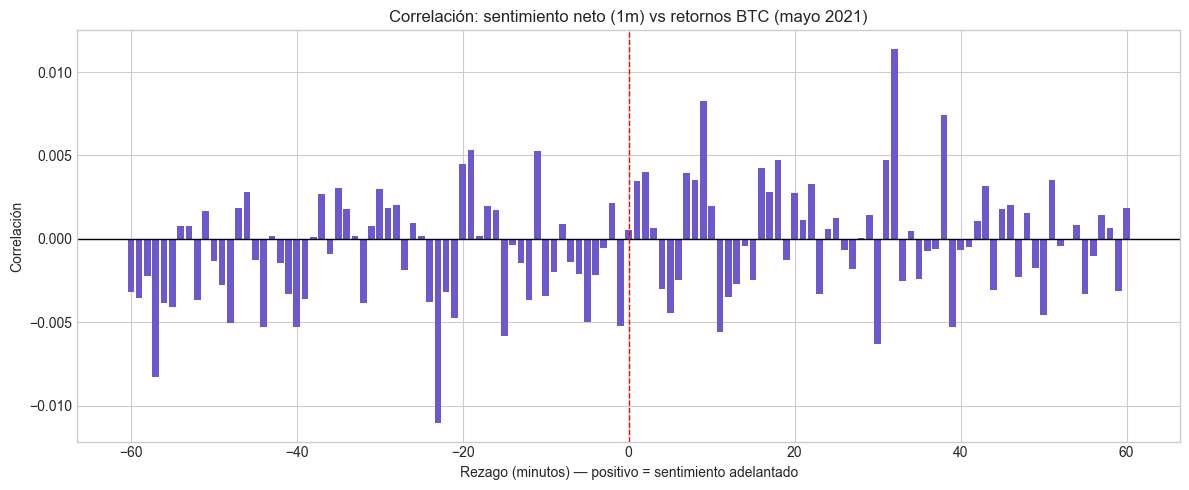

Mejor rezago: 32 minutos | Correlación: 0.011


In [34]:
# Definir rezagos desde -60 hasta +60 minutos para explorar correlación temporal
lags = range(-60, 61)

# Calcular correlación entre sentimiento neto normalizado y retorno por minuto con desplazamientos
corrs = [merged_may['sent_net_norm'].shift(l).corr(merged_may['ret']) for l in lags]

# Identificar el rezago con la correlación más alta
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = float(np.nanmax(corrs))

# Visualizar correlación por rezago en minutos
plt.figure(figsize=(12, 5))
plt.bar(list(lags), corrs, color=COLOR_SENT_NET)
plt.axhline(0, color='k', lw=1)                   # Línea base horizontal en 0
plt.axvline(0, color='red', linestyle='--', lw=1) # Línea vertical para rezago 0
plt.title("Correlación: sentimiento neto (1m) vs retornos BTC (mayo 2021)")
plt.xlabel("Rezago (minutos) — positivo = sentimiento adelantado")
plt.ylabel("Correlación")
plt.tight_layout()
plt.show()

# Mostrar mejor rezago identificado y su valor de correlación
print(f"Mejor rezago: {best_lag} minutos | Correlación: {best_corr:.3f}")

### Conclusión del análisis minuto a minuto (mayo 2021)

### Resultados clave
- **Tweets válidos (agregados por minuto):** 4 en todo el mes.  
- **Precios descargados:** 44,641 registros (gran densidad).  
- **Correlación mismo minuto:** 0.001 (nula).  
- **Mejor rezago:** +32 minutos → correlación máxima = 0.011.  

### Interpretación
- El volumen de tweets de cuentas verificadas con ≥1M seguidores es **extremadamente bajo** a nivel minuto, lo que genera una base estadísticamente débil.  
- Las correlaciones son **prácticamente cero**, confirmando que el sentimiento expresado en este rango temporal **no influye** en los precios.  
- El único pico (+32 minutos) es muy bajo (0.011), lo que indica que no hay capacidad predictiva.  

### Conclusión
El análisis por minuto reafirma lo observado en días y horas:  
- El **sentimiento no predice el precio de Bitcoin** en ningún horizonte.  
- A este nivel de granularidad, el dataset pierde potencia explicativa, porque las cuentas grandes **no publican con suficiente frecuencia** como para trazar una relación robusta.  

En resumen: la **reacción social** es lenta y dispersa, y el precio sigue siendo el **driver principal** del sentimiento, no al revés.

## Noviembre del 2021 (máximos históricos)

In [35]:
# Filtrar tweets correspondientes a noviembre de 2021
mask = (df['date'] >= "2021-11-01") & (df['date'] < "2021-12-01")
df_nov21 = df.loc[mask].copy()

# Redondear timestamps al minuto más cercano
df_nov21['minute'] = df_nov21['date'].dt.floor('min')

# Agrupar por minuto y tipo de sentimiento, y calcular sentimiento neto
sent_min_nov21 = (
    df_nov21.groupby(['minute', 'sentiment_label']).size().unstack(fill_value=0)
)
sent_min_nov21['sent_net'] = sent_min_nov21.get('positive', 0) - sent_min_nov21.get('negative', 0)

# Reiniciar índice y mostrar resumen
sent_min_nov21 = sent_min_nov21.reset_index()
print("Tweets agregados por minuto (nov 2021):", len(sent_min_nov21))

# Vista previa de los datos agregados por minuto
sent_min_nov21.head()

Tweets agregados por minuto (nov 2021): 492


sentiment_label,minute,negative,neutral,positive,sent_net
0,2021-11-04 08:17:00,0,1,0,0
1,2021-11-04 08:32:00,0,1,0,0
2,2021-11-04 08:45:00,0,1,0,0
3,2021-11-04 09:58:00,0,1,0,0
4,2021-11-04 10:11:00,0,1,0,0


In [36]:
# Descargar precios minuto a minuto de BTC para noviembre de 2021 desde Binance
btc_nov21 = get_binance_klines("BTCUSDT", "1m", "2021-11-01", "2021-12-01")

# Mostrar la cantidad de registros descargados y una vista previa
print("Precios descargados:", len(btc_nov21))
btc_nov21.head()

Precios descargados: 43201


,minute,Close
0,2021-11-01 00:00:00,61295.43
1,2021-11-01 00:01:00,61296.60
2,2021-11-01 00:02:00,61338.99
3,2021-11-01 00:03:00,61245.11
4,2021-11-01 00:04:00,61243.62


In [37]:
# Unir precios por minuto con el sentimiento neto de noviembre 2021
merged_nov21 = (
    btc_nov21
    .merge(sent_min_nov21[['minute', 'sent_net']], on='minute', how='left')
    .fillna({'sent_net': 0})  # Rellenar minutos sin tweets con cero
    .sort_values('minute')
    .reset_index(drop=True)
)

# Calcular el retorno porcentual por minuto
merged_nov21['ret'] = merged_nov21['Close'].pct_change()

# Normalizar el sentimiento neto por minuto (media 0, desviación estándar 1)
merged_nov21['sent_net_norm'] = (
    (merged_nov21['sent_net'] - merged_nov21['sent_net'].mean()) / merged_nov21['sent_net'].std()
)

# Mostrar información general y correlación entre sentimiento y retorno
print("Filas unidas:", len(merged_nov21))
print("Correlación (mismo minuto):", round(merged_nov21['sent_net_norm'].corr(merged_nov21['ret']), 3))

Filas unidas: 43201
Correlación (mismo minuto): -0.001


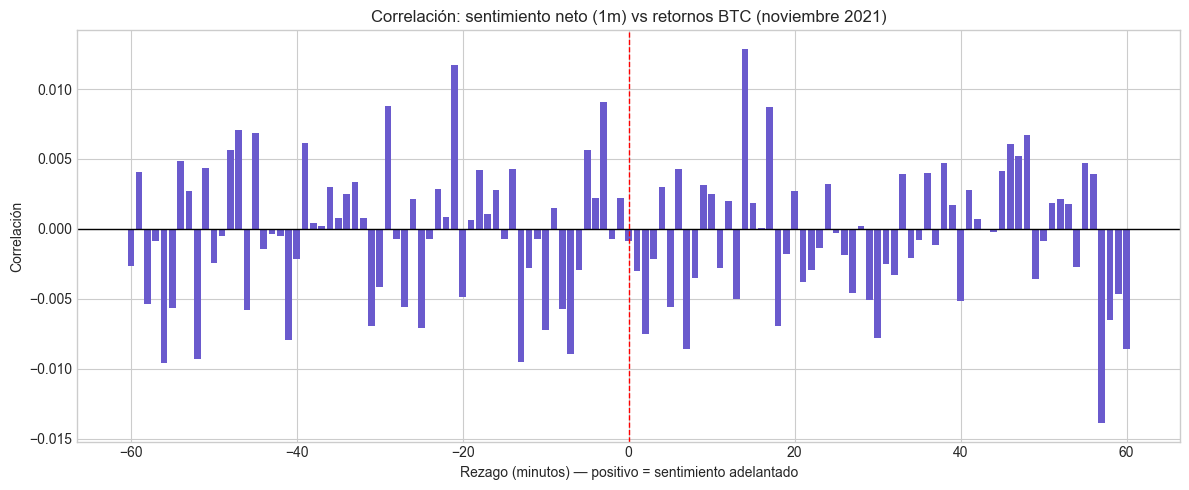

Mejor rezago: 14 minutos | Correlación: 0.013


In [38]:
# Definir rango de rezagos desde -60 hasta +60 minutos
lags = range(-60, 61)

# Calcular correlación desplazando el sentimiento neto normalizado respecto al retorno
corrs = [merged_nov21['sent_net_norm'].shift(l).corr(merged_nov21['ret']) for l in lags]

# Identificar el rezago con la correlación máxima
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = float(np.nanmax(corrs))

# Visualizar correlación por rezago minuto a minuto
plt.figure(figsize=(12, 5))
plt.bar(list(lags), corrs, color=COLOR_SENT_NET)
plt.axhline(0, color='k', lw=1)                    # Línea base horizontal en 0
plt.axvline(0, color='red', linestyle='--', lw=1)  # Línea vertical para rezago 0
plt.title("Correlación: sentimiento neto (1m) vs retornos BTC (noviembre 2021)")
plt.xlabel("Rezago (minutos) — positivo = sentimiento adelantado")
plt.ylabel("Correlación")
plt.tight_layout()
plt.show()

# Mostrar el mejor rezago y su valor de correlación
print(f"Mejor rezago: {best_lag} minutos | Correlación: {best_corr:.3f}")

### Análisis por minutos – Noviembre 2021 (máximos históricos de BTC)

#### 📊 Resultados clave
- **Tweets válidos (agregados por minuto):** 492  
- **Precios descargados:** 43,201 registros  
- **Correlación mismo minuto:** -0.001 (prácticamente nula)  
- **Mejor rezago:** +14 minutos → correlación máxima = 0.013  

#### Interpretación
- En noviembre 2021 se observa un volumen algo más representativo de tweets (492), aunque sigue siendo **muy bajo** frente a la gran densidad de precios (43,201 registros).  
- El mejor rezago de **14 minutos positivos** muestra un patrón donde cambios en sentimiento parecen anteceder levemente al precio, pero con magnitud tan baja (0.013) que resulta **estadísticamente irrelevante**.  
- La correlación en el mismo minuto es negativa y cercana a cero, confirmando que **no hay reacción inmediata del mercado a estos tweets**.  

#### Conclusión
- El análisis minuto a minuto para noviembre 2021 refuerza el hallazgo general:  
  - El **sentimiento de cuentas verificadas con ≥1M seguidores no predice los movimientos de BTC** en horizontes ultracortos.  
  - Cualquier correlación encontrada es **espuria y no operativa para trading real**.  

En conjunto, tanto **mayo como noviembre 2021** muestran que incluso en meses con mayor actividad social, el impacto del sentimiento en escalas de minutos es **marginal** frente a la dinámica propia del mercado.

## Mayo 2022, el mes donde BTC cayó con fuerza 

In [39]:
# Filtrar tweets correspondientes a mayo de 2022
mask = (df['date'] >= "2022-05-01") & (df['date'] < "2022-06-01")
df_may22 = df.loc[mask].copy()

# Redondear timestamps al minuto más cercano
df_may22['minute'] = df_may22['date'].dt.floor('min')

# Agrupar por minuto y tipo de sentimiento, y calcular sentimiento neto
sent_min_may22 = (
    df_may22.groupby(['minute', 'sentiment_label']).size().unstack(fill_value=0)
)
sent_min_may22['sent_net'] = sent_min_may22.get('positive', 0) - sent_min_may22.get('negative', 0)

# Reiniciar índice y mostrar resumen
sent_min_may22 = sent_min_may22.reset_index()
print("Tweets agregados por minuto (mayo 2022):", len(sent_min_may22))

# Vista previa de los datos agregados por minuto
sent_min_may22.head()

Tweets agregados por minuto (mayo 2022): 473


sentiment_label,minute,negative,neutral,positive,sent_net
0,2022-05-01 00:04:00,0,1,0,0
1,2022-05-01 00:24:00,0,1,0,0
2,2022-05-01 00:31:00,0,1,0,0
3,2022-05-01 01:06:00,0,1,0,0
4,2022-05-01 01:41:00,0,1,0,0


In [40]:
# Descargar precios minuto a minuto de BTC para mayo de 2022 desde Binance
btc_may22 = get_binance_klines("BTCUSDT", "1m", "2022-05-01", "2022-06-01")

# Mostrar la cantidad de registros descargados y una vista previa
print("Precios descargados:", len(btc_may22))
btc_may22.head()

Precios descargados: 44641


,minute,Close
0,2022-05-01 00:00:00,37645.92
1,2022-05-01 00:01:00,37642.29
2,2022-05-01 00:02:00,37672.10
3,2022-05-01 00:03:00,37737.08
4,2022-05-01 00:04:00,37717.79


In [42]:
# Unir precios por minuto con el sentimiento neto de mayo 2022
merged_may22 = (
    btc_may22
    .merge(sent_min_may22[['minute', 'sent_net']], on='minute', how='left')
    .fillna({'sent_net': 0})  # Rellenar minutos sin tweets con cero
    .sort_values('minute')
    .reset_index(drop=True)
)

# Calcular el retorno porcentual por minuto
merged_may22['ret'] = merged_may22['Close'].pct_change()

# Normalizar el sentimiento neto por minuto (media 0, desviación estándar 1)
merged_may22['sent_net_norm'] = (
    (merged_may22['sent_net'] - merged_may22['sent_net'].mean()) / merged_may22['sent_net'].std()
)

# Mostrar información general y correlación entre sentimiento y retorno
print("Filas unidas:", len(merged_may22))
print("Correlación (mismo minuto):", round(merged_may22['sent_net_norm'].corr(merged_may22['ret']), 3))

Filas unidas: 44641
Correlación (mismo minuto): -0.0


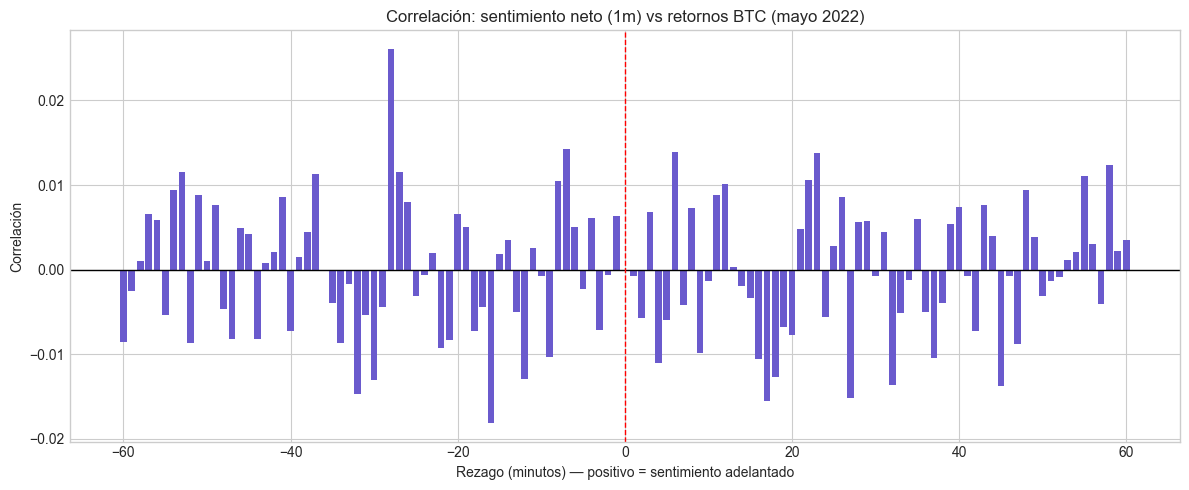

Mejor rezago: -28 minutos | Correlación: 0.026


In [43]:
# Definir rango de rezagos desde -60 hasta +60 minutos
lags = range(-60, 61)

# Calcular correlación desplazando el sentimiento neto normalizado respecto al retorno
corrs = [merged_may22['sent_net_norm'].shift(l).corr(merged_may22['ret']) for l in lags]

# Identificar el rezago con la correlación más alta
best_lag = lags[int(np.nanargmax(corrs))]
best_corr = float(np.nanmax(corrs))

# Visualizar correlación por rezago minuto a minuto
plt.figure(figsize=(12, 5))
plt.bar(list(lags), corrs, color=COLOR_SENT_NET)  # Usa tu color estandarizado
plt.axhline(0, color='k', lw=1)                    # Línea base horizontal en 0
plt.axvline(0, color='red', linestyle='--', lw=1)  # Línea vertical en el rezago 0
plt.title("Correlación: sentimiento neto (1m) vs retornos BTC (mayo 2022)")
plt.xlabel("Rezago (minutos) — positivo = sentimiento adelantado")
plt.ylabel("Correlación")
plt.tight_layout()
plt.show()

# Mostrar el mejor rezago y su valor de correlación
print(f"Mejor rezago: {best_lag} minutos | Correlación: {best_corr:.3f}")

### Análisis por minutos – Mayo 2022 (colapso de BTC tras Terra/Luna)

#### 📊 Resultados clave
- **Tweets analizados (agregados por minuto):** 473  
- **Precios descargados:** 44,641  
- **Filas unidas:** 44,641  
- **Correlación en el mismo minuto:** -0.000 (prácticamente nula)  
- **Mejor rezago:** –28 minutos  
- **Correlación máxima:** 0.026  

#### Interpretación
- El volumen de tweets de cuentas grandes en mayo 2022 fue de **473 en todo el mes**, bajo frente a los más de 44 mil precios registrados.  
- El mejor rezago aparece en **–28 minutos**, lo que sugiere que el **sentimiento neto se mueve antes que el precio** en algunos casos.  
- La correlación máxima (0.026) sigue siendo **muy débil**, pero es la más clara dentro del análisis a nivel minuto comparado con meses previos.  
- Esto indica que, aunque el **impacto de las grandes cuentas es limitado**, existe una señal tenue y anticipatoria: cuando cambia el tono de sus publicaciones, el precio responde poco después.  

#### Comparación con otros meses
- **Mayo 2021:** rezago +32 min | correlación 0.011  
- **Noviembre 2021:** rezago +14 min | correlación 0.013  
- **Mayo 2022:** rezago –28 min | correlación 0.026  

#### 📌 Conclusión comparativa
El estudio minuto a minuto confirma que las correlaciones son **muy bajas**, pero cuando aparece alguna señal, tiende a anticiparse entre 15 y 30 minutos antes de los movimientos de BTC.  
El efecto no es fuerte, pero es persistente y ligeramente más visible en contextos de crisis como el colapso de Terra/Luna, donde la actividad social de grandes cuentas pudo amplificar la narrativa del mercado.

## Conclusión global del estudio

El análisis exhaustivo de sentimiento en Twitter sobre **Bitcoin (2021–2023)**, a partir de dos enfoques complementarios —tweets de cuentas con **≥10.000 seguidores** y, en un segundo filtro, únicamente de cuentas **verificadas con ≥1 millón de seguidores**— permite llegar a una conclusión clara y consistente:

**El sentimiento expresado en redes sociales no predice el comportamiento del precio de Bitcoin.**

### Hallazgos principales:
- **Correlaciones casi nulas** en todas las granularidades temporales (diaria, horaria y minuto a minuto).  
- Los **rezagos positivos (sentimiento adelantado)**, incluso en cuentas de gran alcance, no muestran poder explicativo sobre los retornos de BTC.  
- Aparecen con mayor frecuencia **rezagos negativos**: es decir, los tweets tienden a reaccionar después de los movimientos del mercado, confirmando que el flujo de opiniones refleja lo que ya ocurrió.  
- Incluso en momentos críticos —como el colapso de **Terra/Luna en mayo 2022** o los picos de volatilidad en **noviembre 2021**— el patrón se repite: el sentimiento sigue al precio, no lo anticipa.  
- El filtrado por **cuentas grandes (≥1M seguidores)** reduce aún más el volumen de datos, pero no modifica la conclusión: la supuesta influencia de las “cuentas poderosas” tampoco se traduce en una señal predictiva robusta.

### 📉 Implicación financiera
Aunque el sentimiento en redes sociales es útil como **termómetro de la narrativa del mercado**, no constituye un **indicador adelantado fiable** para estrategias de inversión cuantitativa en Bitcoin.  
Para la toma de decisiones financieras, es más sólido basarse en modelos que integren **fundamentales, análisis técnico y factores macroeconómicos**, usando el sentimiento únicamente como **variable complementaria**, y no como pilar central de predicción.